# Trial for own CNN w/ pixel-targeting


In [312]:
import random
import numpy as np
import pandas as pd

import json
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm as tq
import time

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, metrics
from keras.models import load_model
from keras.preprocessing import image
from keras.utils import load_img
from keras.utils import img_to_array

-------------------------
## Import data


Loading the Image

dtype('float32')

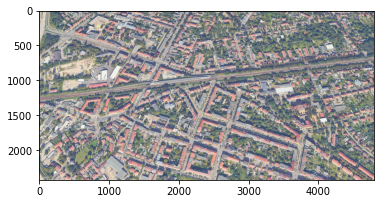

In [27]:
# load the image to get its shape
orig_image = load_img('Potsdam02s.jpg')
i_width, i_height = orig_image.size
# convert to numpy array
image = img_to_array(orig_image)
# scale pixel values to [0, 1]
image = image.astype('float32')
image /= 255.0

plt.imshow(orig_image)

Loading the label-points for the picture from label studio

In [3]:
# load json
orig_labels = pd.read_json(r'Potsdam02s_min.json')
orig_labels = orig_labels['kp-1']
print("The following label-sets were uploaded:")
print(orig_labels)

# retrieve coordinates of labels
labels_x = np.array([])
labels_y = np.array([])
for part in orig_labels:
    for line in part:
        labels_x = np.append(labels_x, line["x"])
        labels_y = np.append(labels_y, line["y"])
        #labels_y.append(line["y"])
labels_unscaled = np.vstack((labels_x, labels_y)).transpose()
print(f"There are {labels_unscaled[:,0].shape} labeled trees in the picture")
labels_unscaled.dtype

The following label-sets were uploaded:
0    [{'x': 13.981023268942872, 'y': 11.34201867765...
1    [{'x': 0.152121599360855, 'y': 3.2678135645587...
Name: kp-1, dtype: object
There are (1415,) labeled trees in the picture


dtype('float64')

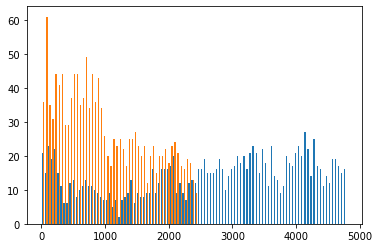

In [265]:
# scale datapoints to image pixels
reshaper = [[(i_width/100), 0], [0,(i_height/100)]]
labels = np.mat(labels_unscaled) * np.mat(reshaper)
# check label positions
histogram_labels = plt.hist(labels, bins=100)

Matching Image and labels and show upload result

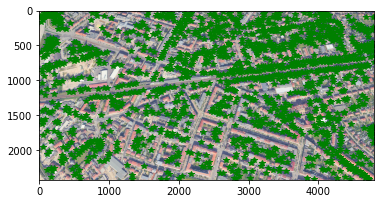

In [5]:
plt.imshow(image)

# plot each labeled tree
for dot in labels:
    #print(dot[:,1])
    plt.plot(dot[:,0], dot[:,1], marker='*', color="green")
# show the plot
plt.show()

-------------------------
## Prepare tiles 
Tiles = child-pictures of image, all together represent the whole image
- split the picture into tiles

In [275]:
# define the tile size
tile_size = 30
num_horizontal_tiles = i_width // tile_size
num_vertical_tiles = i_height // tile_size
num_tiles = num_horizontal_tiles * num_vertical_tiles
print(f"There are {num_tiles} tiles at {tile_size}x{tile_size} pixels")
print(f"There are {num_horizontal_tiles} horizontal tile columns and {num_vertical_tiles} vertical tile rows")

# prepare variables for the tiles
image = np.array(image) # input image
tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images
tile = np.zeros((tile_size, tile_size, 3)) # image of tile
tile_locations = np.zeros((num_tiles, 3)) # (row, column, label_id)

# create tiles
for i in tq(range(num_vertical_tiles)):
    for j in range(num_horizontal_tiles):
        tile_num = i * num_horizontal_tiles + j
        # give starting pixels in rows and columns
        v_start = i * tile_size
        h_start = j * tile_size
        # create tile
        tile = image[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
        # add tile to array
        tiles[tile_num] = tile
        # store location ot tiles:
        tile_locations[tile_num] = (i,j,0)

print(f"Tiles are created: {tiles.shape}.")

There are 12800 tiles at 30x30 pixels
There are 160 horizontal tile columns and 80 vertical tile rows


100%|██████████| 80/80 [00:00<00:00, 652.37it/s]

Tiles are created: (12800, 30, 30, 3).


In [276]:
# Labeling the tiles

tile_labels = np.zeros((num_tiles, 1)) # labels for each tile: 0 = no tree, 1 = tree
tile_count = np.zeros((num_tiles, 1)) # number of trees in each tile
label_count = 0

for label in labels:
    pos_horizontal = label[:,0] // tile_size -1
    pos_vertical = label[:,1] // tile_size -1
    tile_num = int(pos_vertical * num_horizontal_tiles + pos_horizontal)
    tile_labels[tile_num] = 1
    tile_count[tile_num] += 1
    tile_locations[tile_num][2]= label_count
    label_count += 1

print(f"Labels vector is created: {tile_labels.shape}.")
print(f"Tiles labeled as with tree: {tile_labels.sum()}")
print(f"This is {tile_labels.sum()/tile_labels.shape[0]*100}% of the tiles.")
print(f"Total trees assigned: {tile_count.sum()}.")

Labels vector is created: (12800, 1).
Tiles labeled as with tree: 1379.0
This is 10.7734375% of the tiles.
Total trees assigned: 1415.0.


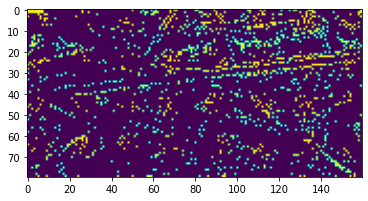

In [299]:
# show labeled tiles
tiles_show = tile_locations[:,2].reshape(num_vertical_tiles, num_horizontal_tiles)
tiles_show[tiles_show == 0] = 0
tiles_show[tiles_show > 0] = 1
plt.imshow(tiles_show)

3.0


(array([1.1421e+04, 0.0000e+00, 0.0000e+00, 1.3450e+03, 0.0000e+00,
        0.0000e+00, 3.2000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

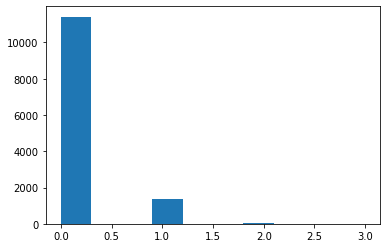

In [310]:
# max count tile show
print(tile_count.max())
plt.hist(tile_count)

tile_num is: 6730
column: 10 of 160, row: 42 of 80
Tile label: [0.]
Tile tree count: [0.]


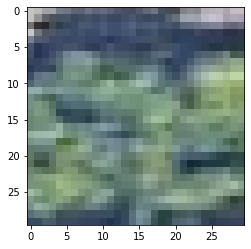

In [263]:
example = random.randint(0, num_tiles-1)
print(f"tile_num is: {example}")
print(f"column: {example % num_horizontal_tiles} of {num_horizontal_tiles}, row: {example // num_horizontal_tiles} of {num_vertical_tiles}")
print(f"Tile label: {tile_labels[example]}")
print(f"Tile tree count: {tile_count[example]}")
plt.imshow(tiles[example])
plt.show()

## Prepare training and validation set

In [331]:
# split the tiles into training and validation set
train_split = 0.8

train_tiles = tiles[:int(num_tiles*train_split)]
train_labels = tile_labels[:int(num_tiles*train_split)]
val_tiles = tiles[int(num_tiles*train_split):]
val_labels = tile_labels[int(num_tiles*train_split):]
print(f"Training set: {train_tiles.shape} - ({train_split} share of all tiles)")
print(f"Validation set: {val_tiles.shape}")

Training set: (10240, 30, 30, 3) - (0.8 share of all tiles)
Validation set: (2560, 30, 30, 3)


(2560, 1)

In [335]:
# build tensorflow dataset
dataset_train_original = tf.data.Dataset.from_tensor_slices((train_tiles, train_labels))
dataset_validate_original = tf.data.Dataset.from_tensor_slices((val_tiles, val_labels))

In [357]:
def encode(tile, label):
    image_encoded = tf.image.convert_image_dtype(tile, dtype=tf.float32)
    image_encoded = tf.image.resize(image_encoded, (tile_size, tile_size))
    return image_encoded, label

batch_size = 32
dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache().shuffle(25).batch(batch_size)
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache().batch(batch_size)

-------
# Training
----



## model


In [371]:
model = models.Sequential()
initializer = tf.keras.initializers.GlorotUniform(seed=42)
model.add(layers.Input(shape=(tile_size, tile_size, 3)))

model.add(layers.Conv2D(20, (3,3), activation="relu", padding="same"))
model.add(layers.ZeroPadding2D(padding=(2,2), data_format=None))

model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(30, (3,3), activation="relu", padding="same"))
model.add(layers.ZeroPadding2D(padding=(1, 1), data_format=None))

model.add(layers.Flatten())
model.add(layers.Dense(5, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=initializer))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 20)        560       
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 34, 34, 20)       0         
 ng2D)                                                           
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 20)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 30)        5430      
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 19, 19, 30)       0         
 ng2D)                                                           
                                                      

## Train a model

In [373]:
model_name = "02"
epochs = 20

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate,
)

Epoch 1/50


/home/luise/anaconda3/envs/eagle/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


320/320 [==============================] - 6s 16ms/step - loss: 0.3316 - binary_accuracy: 0.8844 - val_loss: 0.2502 - val_binary_accuracy: 0.9238
Epoch 2/50
320/320 [==============================] - 5s 16ms/step - loss: 0.3293 - binary_accuracy: 0.8844 - val_loss: 0.2497 - val_binary_accuracy: 0.9238
Epoch 3/50
320/320 [==============================] - 5s 15ms/step - loss: 0.3269 - binary_accuracy: 0.8844 - val_loss: 0.2508 - val_binary_accuracy: 0.9238
Epoch 4/50
320/320 [==============================] - 5s 16ms/step - loss: 0.3272 - binary_accuracy: 0.8844 - val_loss: 0.2494 - val_binary_accuracy: 0.9238
Epoch 5/50
320/320 [==============================] - 5s 15ms/step - loss: 0.3228 - binary_accuracy: 0.8844 - val_loss: 0.2521 - val_binary_accuracy: 0.9238
Epoch 6/50
320/320 [==============================] - 5s 17ms/step - loss: 0.3195 - binary_accuracy: 0.8844 - val_loss: 0.2533 - val_binary_accuracy: 0.9238
Epoch 7/50
320/320 [==============================] - 6s 18ms/step - 

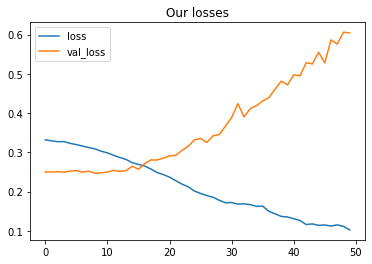

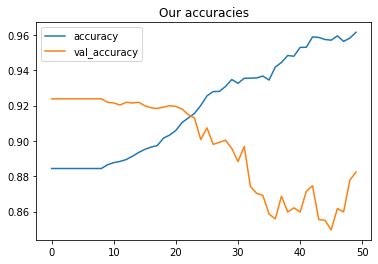

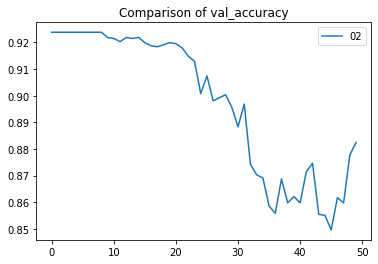

In [376]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["binary_accuracy"], label="accuracy")
    plt.plot(history["val_binary_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()


def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_binary_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()

history_list = {}
history_list[model_name] = history.history
render_history(history.history)
compare_histories()
tf.keras.backend.clear_session()

-------------------------
## Predict


In [377]:
# predict
predictions = model.predict(tiles)
predictions.shape

400/400 [==============================] - 2s 4ms/step


(12800, 1)

In [389]:
# Results of the self-prediction:
threshold = 0.3

predictions = [1 if x > threshold else 0 for x in predictions]
#count true predictions
true_predictions = [1 if x == y else 0 for x, y in zip(predictions, tile_labels)]
true_predictions_count = sum(true_predictions)

print(f"Predictions: {true_predictions_count} out of {len(predictions)} labels are identified as trees.")
# show labeled tiles
tiles_show = predictions.reshape(num_vertical_tiles, num_horizontal_tiles)
plt.imshow(tiles_show)

Predictions: 11479 out of 12800 labels are identified as trees.


AttributeError: 'list' object has no attribute 'reshape'

-------------------------
## Save predictions


In [ ]:
# save predictions
np.savetxt('predictions_own_cnn_pixel_targeting_25tiles.txt', predictions)